# Random polymer loop
This example shows you how to run a simple polymer simulation in hoomdd.

Here is a script that generates a system of bead-spring polymers that self-assemble into a hex phase when run for a few million time steps. The polymers are A6B7A6 block copolymers in an implicit solvent. The script also shows a few examples of how writing python code in the script can be handy: here the concentration phi_P is a parameter and math operations are performed to calculate the length of the box.

For more information on the model in this script, see
"Micellar crystals in solution from molecular dynamics simulations"
J. Chem. Phys. 128, 184906 (2008); DOI:10.1063/1.2913522
http://link.aip.org/link/?JCPSA6/128/184906/1

Any of the polymer systems in the paper could be easily run just by changing a few parameters in this script.
from: https://lost-contact.mit.edu/afs//umich.edu/user/j/o/joaander/Public/hoomd-web/doc/page_example_scripts.html

## Initialize
First import hoomd and associated libraries and then initialize.  If no mode is given then the fastest processor cpu or gpu will be selected automatically.

In [1]:
import hoomd
from hoomd import *
from hoomd import md
from hoomd import deprecated
#hoomd.context.initialize();
#hoomd.context.initialize("--mode=cpu");
hoomd.context.initialize("--mode=gpu");

HOOMD-blue 2.2.4-unknown CUDA (8.0) DOUBLE HPMC_MIXED SSE SSE2 SSE3 SSE4_1 SSE4_2 AVX AVX2 
Compiled: 03/13/2018
Copyright 2009-2017 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
notice(2): This system is not compute exclusive, using local rank to select GPUs
HOOMD-blue is running on the following GPU(s):
 [0]      GeForce GTX 775M   7 SM_3.0 @ 0.797 GHz, 2047 MiB DRAM, DIS


## Import other libraries and define parameters

In [2]:
#import math
import math
# parameters (polymer physics)
phi_P = 0.25 # this has to do with how good of a solvent the polymer is in and is only used to calculate the box size below
n_poly = 10 # n_poly in the number of polymers in the simulation
n_beads = 8

## Define the polymer

In [3]:
# This polymer can be made up of two different types A and B.  It's called a block copolymer.
polymer1 = dict(bond_len=1.2, type=['B']*1 + ['A']*n_beads + ['B']*1 + ['A']*n_beads + ['B']*1,bond="linear", count=n_poly)
#polymer2 = dict(bond_len=1.2, type=['B']*1 + ['A']*178 + ['B']*1,bond="linear", count=1)
#polymer3 = dict(bond_len=1.2, type=['B']*1 + ['A']*158 + ['B']*1,bond="linear", count=1)
#polymer4 = dict(bond_len=1.2, type=['B']*1 + ['A']*138 + ['B']*1,bond="linear", count=1)
#polymer5 = dict(bond_len=1.2, type=['B']*1 + ['A']*118 + ['B']*1,bond="linear", count=1)
#polymer6 = dict(bond_len=1.2, type=['B']*1 + ['A']*98 + ['B']*1,bond="linear", count=1)
#polymer7 = dict(bond_len=1.2, type=['B']*1 + ['A']*78 + ['B']*1,bond="linear", count=1)
#polymer8 = dict(bond_len=1.2, type=['B']*1 + ['A']*58 + ['B']*1,bond="linear", count=1)
#polymer9 = dict(bond_len=1.2, type=['B']*1 + ['A']*38 + ['B']*1,bond="linear", count=1)
#polymer10 = dict(bond_len=1.2, type=['B']*1 + ['A']*18 + ['B']*1,bond="linear", count=1)

# perform some simple math to find the length of the box
N = len(polymer1['type']) * polymer1['count']
# generate the polymer system
system=deprecated.init.create_random_polymers(\
                                              box=data.boxdim(volume=1000*math.pi * N / (6.0 * phi_P)), \
                                              polymers=[polymer1],\
                                              separation=dict(A=0.35, B=0.35)\
                                              ,seed=12)


notice(2): Group "all" created containing 190 particles


## Setup the bonds and force fields

In [4]:
# force field setup
harmonic = md.bond.harmonic()
harmonic.bond_coeff.set('polymer', k=330.0, r0=0.84)
nl = md.nlist.cell();
lj = md.pair.lj(r_cut=3.0,nlist=nl)
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0, alpha=0.0)
lj.pair_coeff.set('A', 'B', epsilon=1.0, sigma=1.0, alpha=0.0)
lj.pair_coeff.set('B', 'B', epsilon=20.0, sigma=1.0, alpha=1.0)

## Integrate the simulation

In [5]:
import numpy
import math
# integrate NVT for a bunch of time steps
all = group.all()
md.integrate.mode_standard(dt=0.005)
md.integrate.nvt(group=all, kT=1.2, tau=0.5)

#save a gsd polymer configuration every 100 timesteps
dump.gsd("gsd/random_polymer_loop.gsd", period=100, group=all, overwrite=True);

#log position of particle 0
polymers=['p1','p2','p3','p4','p5','p6','p7','p8','p9','p10']
log = hoomd.analyze.log(filename="ree.log",
                         quantities=polymers[0:n_poly],
                         period=100,
                         overwrite=True);

for i in range(n_poly):
    print(polymers[i],(n_beads+2)*i,(n_beads+2)*i+n_beads+1)
    log.register_callback(polymers[i], lambda timestep,i=i: math.sqrt( \
     (system.particles[(n_beads+2)*i].position[0]-system.particles[(n_beads+2)*i+n_beads+1].position[0])**2\
    +(system.particles[(n_beads+2)*i].position[1]-system.particles[(n_beads+2)*i+n_beads+1].position[1])**2\
    +(system.particles[(n_beads+2)*i].position[2]-system.particles[(n_beads+2)*i+n_beads+1].position[2])**2));
    #print(math.sqrt( \
    # (system.particles[(n_beads+2)*i].position[0]-system.particles[(n_beads+2)*i+n_beads+1].position[0])**2\
    #+(system.particles[(n_beads+2)*i].position[1]-system.particles[(n_beads+2)*i+n_beads+1].position[1])**2\
    #+(system.particles[(n_beads+2)*i].position[2]-system.particles[(n_beads+2)*i+n_beads+1].position[2])**2));

#run(2000)

#hoomd.dump.gsd(filename="gsd/random_polymer_loop_0.gsd", overwrite=True, period=None, group=group.all(), time_step=0)
# setup the IMD server
#hoomd.analyze.imd(port=54321, period=10)
# run a very long time so the simulation can be watched in VMD
run(1e5)

#vmd -e imd2.vmd gsd/create_random_polymer_loop_0.gsd
#!cat imd2.vmd

('p1', 0, 9)
('p2', 10, 19)
('p3', 20, 29)
('p4', 30, 39)
('p5', 40, 49)
('p6', 50, 59)
('p7', 60, 69)
('p8', 70, 79)
('p9', 80, 89)
('p10', 90, 99)
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 1 exclusions             : 20
notice(2): Particles with 2 exclusions             : 170
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 44148 / 100000 | TPS 4414.75 | ETA 00:00:12
Time 00:00:20 | Step 93401 / 100000 | TPS 4924.55 | ETA 00:00:01
Time 00:00:21 | Step 100000 / 100000 | TPS 5018.24 | ETA 00:00:00
Average TPS: 4690.69
---------
-- Neighborlist stats:
10950 normal updates / 334 forced updates / 0 dangerous updates
n_neigh_min: 8 / n_neigh_max: 34 / n_neigh_avg: 15.7895
shortest rebuild period: 3
-- Cell list stats:
Dimension: 21, 21, 21
n_min    : 0 / n_max: 14 / n_avg: 0.0205161
** run complete **


## Plot results and correlation function

timestep	p1	p2	p3	p4	p5	p6	p7	p8	p9	p10
0	2.181745506	11.13730812	6.056008017	47.24131403	4.212070304	9.769309179	3.997861688	62.97734761	3.075004958	29.06997642
100	2.526461313	11.5915197	5.391935047	48.67667717	2.876746818	9.788417211	3.385480664	63.40203438	3.318956896	27.86224832
200	2.531698133	11.70697556	5.431782056	48.78253151	2.965763193	9.87583509	3.616884433	63.22249425	3.339802499	27.79357404
300	2.517717155	11.7129286	5.500968721	48.77027235	2.937125349	9.882312597	3.694888453	63.16068811	3.326925635	27.79063562
400	2.49452519	11.71024401	5.567069301	48.78192443	2.928409732	9.889917809	3.736541942	63.14000465	3.342681163	27.79048517
500	2.444623535	11.69985702	5.676957217	48.80117787	2.916944612	9.895549427	3.802847963	63.1403212	3.387608539	27.78414639
600	2.22885323	11.64353129	5.919072465	48.80557769	2.924013856	9.901587601	3.950030054	63.24430586	3.54406923	27.74343231
700	1.712621468	11.41774477	6.232086269	48.15433419	3.626230736	10.06531821	4.501566328	64.61861366	4

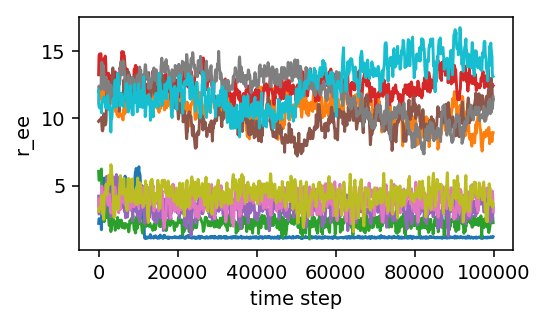

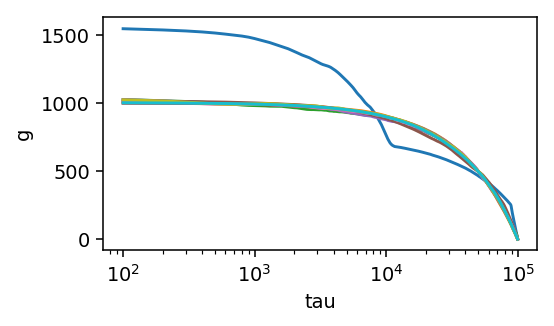

In [ ]:
from matplotlib import pyplot
%matplotlib inline
!head ree.log
data = numpy.genfromtxt(fname='ree.log',skip_header=True);
t=numpy.ndarray.flatten(data[:,0])
r_ee=data[:,1:]#/(101*(0.84**2))
print(numpy.shape(r_ee))
pyplot.figure(figsize=(4,2.2), dpi=140);
#pyplot.plot(t,r_ee);
for i in range(n_poly):
    #pyplot.figure(figsize=(4,2.2), dpi=140);
    pyplot.plot(t[:],r_ee[:,i]%17);
    pyplot.xlabel('time step');
    pyplot.ylabel('r_ee');
#r_ee=r_ee[len(r_ee)/2:]
def autocorr(x):
    result = numpy.correlate(x, x, mode='full')/(numpy.average(x)**2)-1.0
    return result[result.size/2:]
pyplot.figure(figsize=(4,2.2), dpi=140);
for i in range(n_poly):
    #pyplot.figure(figsize=(4,2.2), dpi=140);
    g=autocorr(numpy.ndarray.flatten(r_ee[:,i]))
    pyplot.semilogx(t,g)
    pyplot.xlabel('tau');
    pyplot.ylabel('g');

The results of this example may be visualized with VMD which can be installed from here: http://www.ks.uiuc.edu/Research/vmd/

In [ ]:
!vmd -e vdw.vmd gsd/random_polymer_loop.gsd

Info) VMD for MACOSXX86, version 1.9.4a12 (December 21, 2017)
Info) http://www.ks.uiuc.edu/Research/vmd/                         
Info) Email questions and bug reports to vmd@ks.uiuc.edu           
Info) Please include this reference in published work using VMD:   
Info)    Humphrey, W., Dalke, A. and Schulten, K., `VMD - Visual   
Info)    Molecular Dynamics', J. Molec. Graphics 1996, 14.1, 33-38.
Info) -------------------------------------------------------------
Info) Multithreading available, 4 CPUs detected.
Info) OpenGL renderer: NVIDIA GeForce GTX 775M OpenGL Engine
Info)   Features: STENCIL MDE MTX NPOT PP PS GLSL(OVF) 
Info)   Full GLSL rendering mode is available.
Info)   Textures: 2-D (16384x16384), 3-D (2048x2048x2048), Multitexture (8)
Info) Dynamically loaded 4 plugins in directory:
Info) /Applications/VMD 1.9.4.app/Contents/vmd/plugins/MACOSXX86/molfile
Info) File loading in progress, please wait.
Info) Using plugin gsd for structure file gsd/random_polymer_loop.gsd
Info

[](snapshots/random_polymer_loop.png)

In [ ]:
!echo $PATH